# Process Identification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors

import package_DBR
from package_DBR import *
import package_LAB
from package_LAB import *
from importlib import reload
package_LAB = reload(package_LAB) # reload at each run the newset version of your package

#### Load data

In [2]:
nameFile =  'Open_loop_experiment_on_MV_2023-03-10-10h33.txt'  
    
titleName = nameFile.split('.')[0]    
data = pd.read_csv('Data/' + nameFile)
t = data['t'].values - data['t'].values[0]
MV = data['MV'].values
PV = data['PV'].values
DV = data['DV'].values

#### Clean data

In [3]:
tstep = np.argwhere(np.diff(MV) != 0)
tstep = tstep[0][0]
tm = t[tstep:]
tm = tm - tm[0]    
MVstep = MV[tstep + 1] - MV[tstep]
MVm = MV[tstep:]
PVm = PV[tstep:]
PVm = (PVm - PVm[0])/MVstep
MVm = (MVm - MVm[0])/MVstep    

## Params of P(s)
Process parameters found using various methods listed bellow

In [4]:
# Broida 1
P1 = Process({})
P1.parameters['Kp'] = Kp_P1 = 0.533
P1.parameters['Tlag1'] = T1_P1 = 151
P1.parameters['theta'] = theta_P1 = 17

# Broida 2
P2 = Process({})
P2.parameters['Kp'] = Kp_P2 = 0.533
P2.parameters['Tlag1'] = T1_P2 = 104.5
P2.parameters['theta'] = theta_P2 = 24.8

# Van Der Grinten
P3 = Process({})
P3.parameters['Kp'] = Kp_P3 = 0.533
P3.parameters['Tlag1'] = T1_P3 = 9.38
P3.parameters['Tlag2'] = T2_P3 = 70.81
P3.parameters['theta'] = theta_P3 = 14

# Strejc
P4 = Process({})
P4.parameters['Kp'] = Kp_P4 = 0.533
P4.parameters['Tlag1'] = T1_P4 = 55.5147
P4.parameters['Tlag2'] = T2_P4 = 55.5147
P4.parameters['theta'] = theta_P4 = 1.9

# Auto FOPDT
P5 = Process({})
P5.parameters['Kp'] = Kp_P5 = 0.6890796420174794
P5.parameters['Tlag1'] = T1_P5 = 195.93418960703713
P5.parameters['theta'] = theta_P5 = 6.661942351380765

# Auto SOPDT
P6 = Process({})
P6.parameters['Kp'] = Kp_P6 = 0.6738137025155853
P6.parameters['Tlag1'] = T1_P6 = 183.44770757727215
P6.parameters['Tlag2'] = T2_P6 = 5.327855225788805e-05
P6.parameters['theta'] = theta_P6 = 10.192078303908199

Ts = 1
PV1 = FOPDT(MVm, Kp_P1, T1_P1, theta_P1, Ts)
PV2 = FOPDT(MVm, Kp_P2, T1_P2, theta_P2, Ts)
PV3 = SOPDT(MVm, Kp_P3, T1_P3, T2_P3, theta_P3, Ts)
PV4 = SOPDT(MVm, Kp_P4, T1_P4, T2_P4, theta_P4, Ts)
PV5 = FOPDT(MVm, Kp_P5, T1_P5, theta_P5, Ts)
PV6 = SOPDT(MVm, Kp_P6, T1_P6, T2_P6, theta_P6, Ts)

## Plots
Compare the results

(0.0, 637.0)

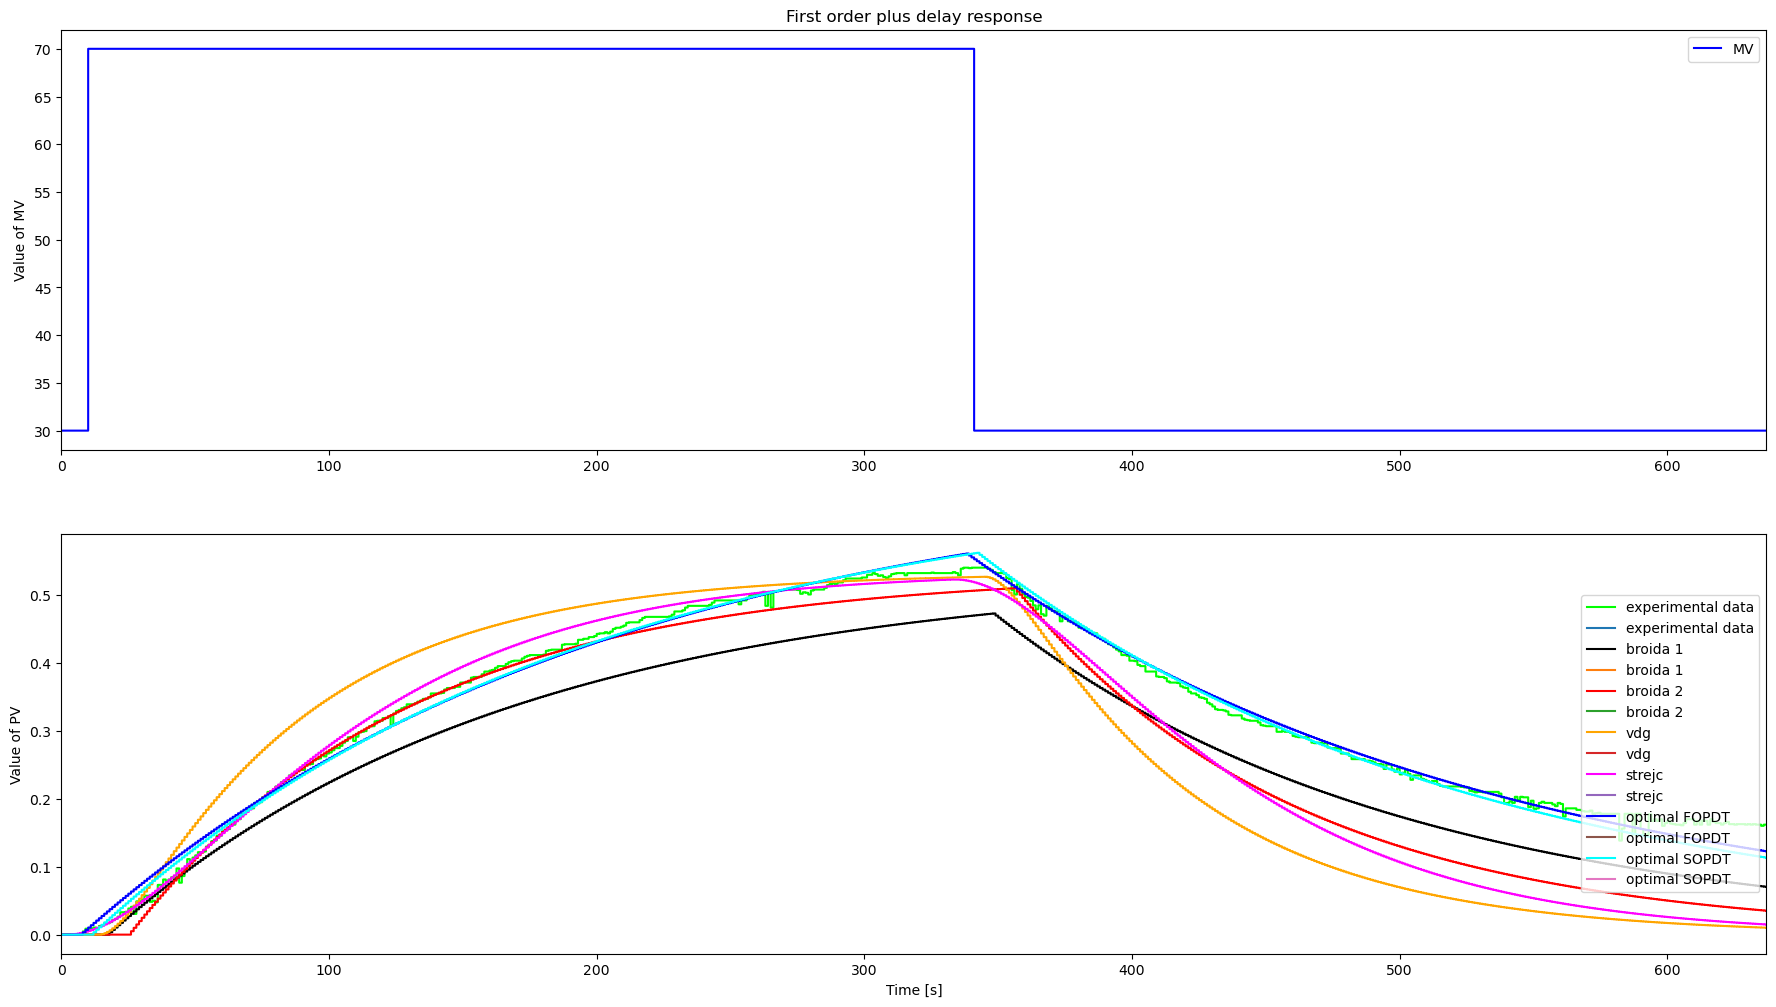

In [32]:
plt.figure(figsize = (22,12))

plt.subplot(2,1,1)
plt.step(t,MV,'b-',label='MV',where='post')
plt.ylabel('Value of MV')
plt.title('First order plus delay response')
plt.legend(loc='best')
plt.xlim([0, tm[-1]])

linewidth = 0.5
plt.subplot(2,1,2) 
plt.step(tm, PVm, 'lime', linewidth, label='experimental data',where='post')
plt.step(tm, PV1, 'black', linewidth, label='broida 1', where='post')
plt.step(tm, PV2, 'red', linewidth, label='broida 2', where='post')
plt.step(tm, PV3, 'orange', linewidth, label='vdg', where='post')
plt.step(tm, PV4, 'magenta', linewidth, label='strejc', where='post')
plt.step(tm, PV5, 'blue', linewidth, label='optimal FOPDT', where='post')
plt.step(tm, PV6, 'cyan', linewidth, label='optimal SOPDT', where='post')

plt.ylabel('Value of PV')
plt.xlabel('Time [s]')
plt.legend(loc='right')
plt.xlim([0, tm[-1]])  

## Bode Diags

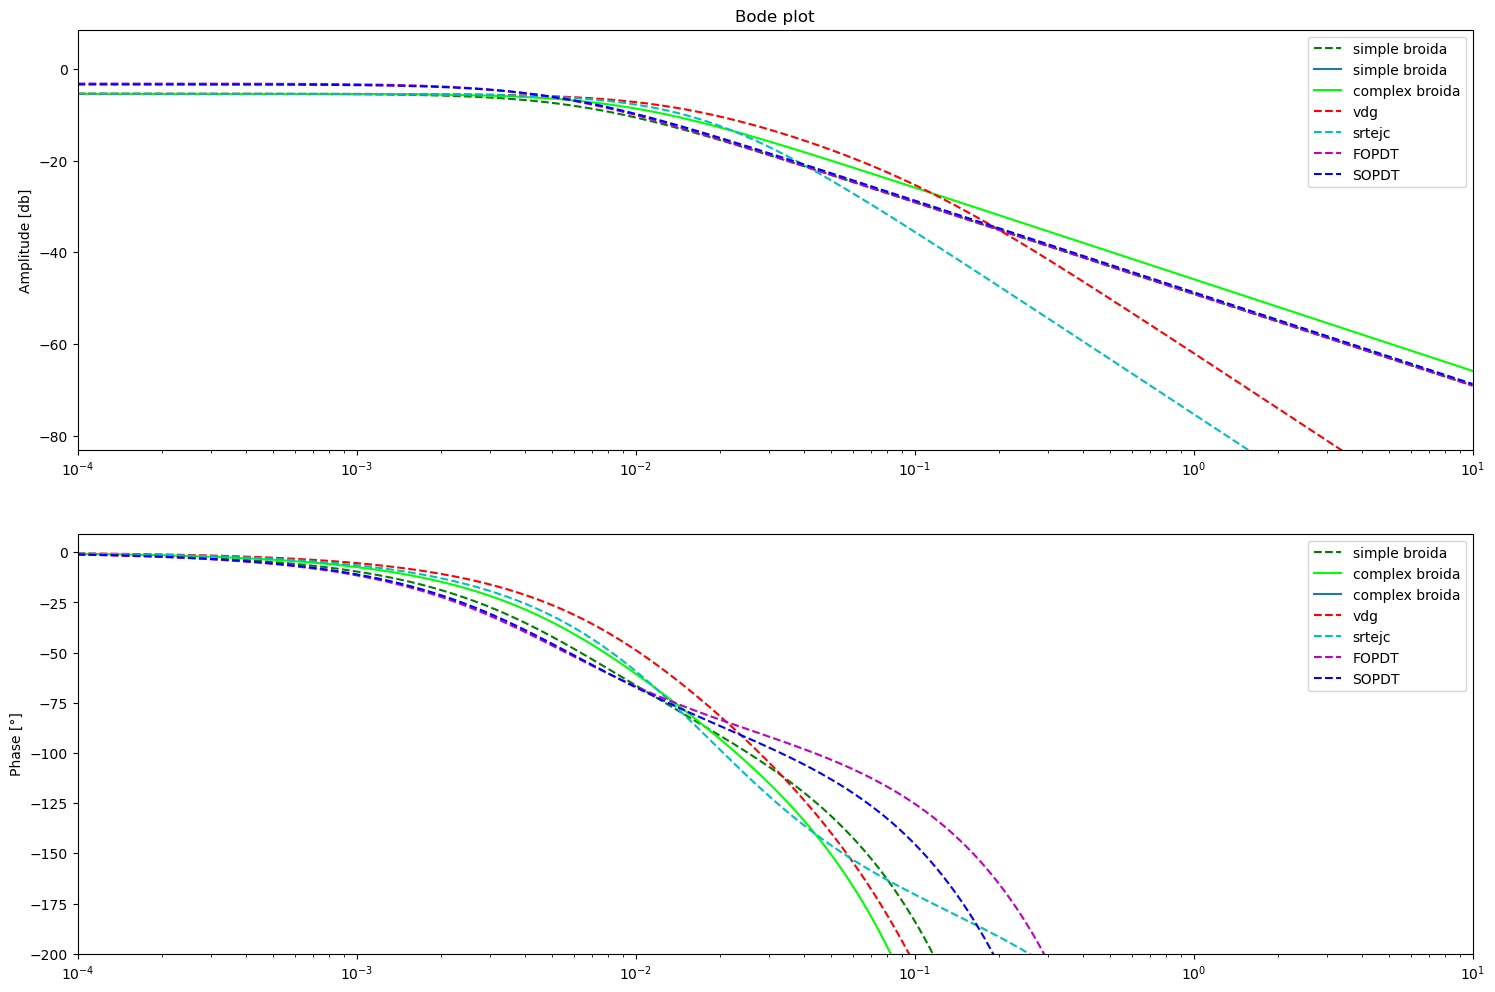

In [45]:
omega = np.logspace(-4, 1, 10000)

Ps1 = Bode(P1,omega,Show=False) # Broida 1
Ps2 = Bode(P2,omega,Show=False) # Broida 2
Ps3 = Bode(P3,omega,Show=False) # Vand Der Grinten
Ps4 = Bode(P4,omega,Show=False) # Strejc
Ps5 = Bode(P5,omega,Show=False) # Auto FOPDT
Ps6 = Bode(P6,omega,Show=False) # Auto SOPDT
plt.figure(figsize = (18,12))

# Gain
plt.subplot(2,1,1)
gain_min = np.min(20*np.log10(np.abs(Ps1)/5))
gain_max = np.max(20*np.log10(np.abs(Ps1)*5))
plt.semilogx(omega, 20*np.log10(np.abs(Ps1)), 'g--', linewidth, label='simple broida')
plt.semilogx(omega, 20*np.log10(np.abs(Ps2)), 'lime', label='complex broida')
plt.semilogx(omega, 20*np.log10(np.abs(Ps3)), 'r--', label='vdg')
plt.semilogx(omega, 20*np.log10(np.abs(Ps4)), 'c--', label='srtejc')
plt.semilogx(omega, 20*np.log10(np.abs(Ps5)), 'm--', label='FOPDT')
plt.semilogx(omega, 20*np.log10(np.abs(Ps6)), 'b--', label='SOPDT')

plt.xlim([np.min(omega), np.max(omega)])
plt.ylim([gain_min, gain_max])
plt.ylabel('Amplitude [db]')
plt.title('Bode plot')
plt.legend(loc='best')

# Phase
plt.subplot(2,1,2)
ph_min = np.min((180/np.pi)*np.unwrap(np.angle(Ps2))) - 10
ph_max = np.max((180/np.pi)*np.unwrap(np.angle(Ps2))) + 10
plt.semilogx(omega, (180/np.pi)*np.unwrap(np.angle(Ps1)), 'g--', label='simple broida')
# Line width issue !!!
plt.semilogx(omega, (180/np.pi)*np.unwrap(np.angle(Ps2)), 'lime', linewidth, label='complex broida')
plt.semilogx(omega, (180/np.pi)*np.unwrap(np.angle(Ps3)), 'r--', label='vdg')
plt.semilogx(omega, (180/np.pi)*np.unwrap(np.angle(Ps4)), 'c--', label='srtejc')
plt.semilogx(omega, (180/np.pi)*np.unwrap(np.angle(Ps5)), 'm--', label='FOPDT')
plt.semilogx(omega, (180/np.pi)*np.unwrap(np.angle(Ps6)), 'b--', label='SOPDT')

plt.xlim([np.min(omega), np.max(omega)])
plt.ylim([np.max([ph_min, -200]), ph_max])
plt.ylabel('Phase [°]')
plt.legend(loc='best')